## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [2]:
# taken more or less directly from the course material for ECG
# From the README we get that sampling rate is 125

def BandpassFilter(signal, low_th, high_th, fs=125):
    b, a = sp.signal.butter(3, (low_th,high_th), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b,a, signal)

In [20]:
# I find the description of "confidence" in this project rather confusing, but will just use the SNR idea
# that was presented in the course material. However, it does not take into account the fact that the movement
# artifacts and the PPG signal happen at same power band...
def CalcSNR(sig, hr_bpm):
    # Our data is sampled at 125 Hz
    fs = 125

    hr_f = hr_bpm / 60

    harmonic_f = hr_f * 2

    low_thr = 40/60
    high_thr = 240/ 60
    sig = BandpassFilter(sig, low_thr, high_thr, fs)
    
    # found this in a knowledge base example:
    # https://knowledge.udacity.com/questions/314330
    n = len(sig) * 3

    freqs = np.fft.rfftfreq(n, 1/fs)
    fft = np.abs(np.fft.rfft(sig,n))
    fft[freqs <= 40/60.0] = 0.0
    fft[freqs >= 240/60.0] = 0.0

    
    est_fs = hr_f / 55.0
    fs_win = 30  / 60.0
    fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
    conf = np.sum(fft[fs_win_e])/np.sum(fft)
        
    return conf


    # freq = np.fft.rfftfreq(len(sig), 1/fs)
    # fft_mag = np.abs(np.fft.rfft(sig, n))
    # fft_mag[freq <= 40/60.0] = 0.0
    # fft_mag[freq >= 240/60.0] = 0.0
    # Compute signal power and noise power

    # window_f = 30 / 60
    # fundamental_frequency_window = (freqs > hr_f - window_f) & (freqs < hr_f + window_f)
    # harmonic_frequency_window = (freqs > harmonic_f - window_f) & (freqs < harmonic_f + window_f)

    # signal_power = np.sum(fft[(fundamental_frequency_window) | (harmonic_frequency_window)]) 
    # noise_power = np.sum(fft[~((fundamental_frequency_window) | (harmonic_frequency_window))]) 


    # Compute SNR
    #snr = signal_power / noise_power
    #return snr



In [4]:
# # I find the description of "confidence" in this project rather confusing, but will just use the SNR idea
# # that was presented in the course material. However, it does not take into account the fact that the movement
# # artifacts and the PPG signal happen at same power band...
# def CalcSNR(sig, hr_bpm):
#     # Our data is sampled at 125 Hz
#     fs = 125

#     hr_f = hr_bpm / 60

#     harmonic_f = hr_f * 2

#     freq = np.fft.rfftfreq(len(sig), 1/fs)
#     fft_mag = np.abs(np.fft.rfft(sig))
#     # Compute signal power and noise power

#     window_f = 30 / 60
#     fundamental_frequency_window = (freq > hr_f - window_f) & (freq < hr_f + window_f)
#     harmonic_frequency_window = (freq > harmonic_f - window_f) & (freq < harmonic_f + window_f)

#     signal_power = np.sum(fft_mag[(fundamental_frequency_window) | (harmonic_frequency_window)]) 
#     noise_power = np.sum(fft_mag[~((fundamental_frequency_window) | (harmonic_frequency_window))]) 


#     # Compute SNR
#     snr = signal_power / noise_power
#     return snr



In [5]:

# Adapted from course material....

def Featurize(accx, accy, accz, ppg, fs):
  """Featurization of the accelerometer signal.

  Args:
      accx: (np.array) x-channel of the accelerometer.
      accy: (np.array) y-channel of the accelerometer.
      accz: (np.array) z-channel of the accelerometer.
      fs: (number) the sampling rate of the accelerometer

  Returns:
      n-tuple of accelerometer features
  """

  low_thr = 40/60
  high_thr = 240/ 60
  accx = BandpassFilter(accx, low_thr, high_thr, fs)
  accy = BandpassFilter(accy,low_thr, high_thr, fs)
  accz = BandpassFilter(accz,low_thr, high_thr, fs)
  ppg = BandpassFilter(ppg,low_thr, high_thr, fs)


  # The mean of each channel
  mn_x = np.mean(accx)
  mn_y = np.mean(accy)
  mn_z = np.mean(accz)
  mn_p= np.mean(ppg)


  # The standard deviation of each channel
  std_x = np.std(accx)
  std_y = np.std(accy)
  std_z = np.std(accz)
  std_p = np.std(ppg)

  # Various percentile values for each channel
  p5_x = np.percentile(accx, 5)
  p5_y = np.percentile(accy, 5)
  p5_z = np.percentile(accz, 5)
  p5_p = np.percentile(ppg, 5)
  p10_x = np.percentile(accx, 10)
  p10_y = np.percentile(accy, 10)
  p10_z = np.percentile(accz, 10)
  p10_p = np.percentile(ppg, 10)
  p25_x = np.percentile(accx, 25)
  p25_y = np.percentile(accy, 25)
  p25_z = np.percentile(accz, 25)
  p25_p = np.percentile(ppg, 25)
  p50_x = np.percentile(accx, 50)
  p50_y = np.percentile(accy, 50)
  p50_z = np.percentile(accz, 50)
  p50_p = np.percentile(ppg, 50)
  p90_x = np.percentile(accx, 90)
  p90_y = np.percentile(accy, 90)
  p90_z = np.percentile(accz, 90)
  p90_p = np.percentile(ppg, 90)

  # The pearson correlation of all pairs of channels
  corr_xy = sp.stats.pearsonr(accx, accy)[0]
  corr_xz = sp.stats.pearsonr(accx, accz)[0]
  corr_yz = sp.stats.pearsonr(accy, accz)[0]
  corr_py = sp.stats.pearsonr(ppg, accy)[0]
  corr_px = sp.stats.pearsonr(ppg, accx)[0]
  corr_pz = sp.stats.pearsonr(ppg, accz)[0]



  # The total energy of each channel
  energy_x = np.sum(np.square(accx - np.mean(accx)))
  energy_y = np.sum(np.square(accy - np.mean(accy)))
  energy_z = np.sum(np.square(accz - np.mean(accz)))
  energy_p = np.sum(np.square(ppg - np.mean(ppg)))


  # Take an FFT of the signal. If the signal is too short, 0-pad it so we have 
  # at least 2046 points in the FFT.
  fft_len = max(len(accx), 2046)

  # Create an array of frequency bins
  fft_freqs = np.fft.rfftfreq(fft_len, 1 / fs)

  # Helper function to select frequency bins between <low> and <high>
  freqs_bw = lambda low, high: (fft_freqs >= low) & (fft_freqs <= high)

  # Compute the accelerometer magnitude
  accm = np.sqrt(np.sum(np.square(np.vstack((accx, accy, accz))), axis=0))

  # Take an FFT of the centered signal
  fft_x = np.fft.rfft(accx, fft_len)
  fft_y = np.fft.rfft(accy, fft_len)
  fft_z = np.fft.rfft(accz, fft_len)
  fft_m = np.fft.rfft(accm, fft_len)
  fft_p = np.fft.rfft(ppg, fft_len)


  # Compute the energy spectrum
  spec_energy_x = np.square(np.abs(fft_x))
  spec_energy_y = np.square(np.abs(fft_y))
  spec_energy_z = np.square(np.abs(fft_z))
  spec_energy_m = np.square(np.abs(fft_m))
  spec_energy_p = np.square(np.abs(fft_p))

  # The frequency with the most power between 0.25 and 12 Hz
  dom_x = fft_freqs[np.argmax(fft_x[freqs_bw(0.25, 12)])]
  dom_y = fft_freqs[np.argmax(fft_y[freqs_bw(0.25, 12)])]
  dom_z = fft_freqs[np.argmax(fft_z[freqs_bw(0.25, 12)])]
  dom_m = fft_freqs[np.argmax(fft_m[freqs_bw(0.25, 12)])]
  dom_p = fft_freqs[np.argmax(fft_p[freqs_bw(0.25, 12)])]


  # The fraction of energy in various frequency bins for each channel
  energy_01_x = (np.sum(spec_energy_x[freqs_bw(0, 1)]) 
                 / np.sum(spec_energy_x))
  energy_01_y = (np.sum(spec_energy_x[freqs_bw(0, 1)]) 
                 / np.sum(spec_energy_y))
  energy_01_z = (np.sum(spec_energy_x[freqs_bw(0, 1)]) 
                 / np.sum(spec_energy_z))
  energy_01_m = (np.sum(spec_energy_x[freqs_bw(0, 1)]) 
                 / np.sum(spec_energy_m))
  energy_01_p = (np.sum(spec_energy_x[freqs_bw(0, 1)]) 
                 / np.sum(spec_energy_p))


  
  energy_12_x = (np.sum(spec_energy_x[freqs_bw(1, 2)]) 
                 / np.sum(spec_energy_x))
  energy_12_y = (np.sum(spec_energy_x[freqs_bw(1, 2)]) 
                 / np.sum(spec_energy_y))
  energy_12_z = (np.sum(spec_energy_x[freqs_bw(1, 2)]) 
                 / np.sum(spec_energy_z))
  energy_12_m = (np.sum(spec_energy_x[freqs_bw(1, 2)]) 
                 / np.sum(spec_energy_m))
  energy_12_p = (np.sum(spec_energy_x[freqs_bw(1, 2)]) 
                 / np.sum(spec_energy_p))
  energy_23_x = (np.sum(spec_energy_x[freqs_bw(2, 3)]) 
                 / np.sum(spec_energy_x))
  energy_23_y = (np.sum(spec_energy_x[freqs_bw(2, 3)]) 
                 / np.sum(spec_energy_y))
  energy_23_z = (np.sum(spec_energy_x[freqs_bw(2, 3)]) 
                 / np.sum(spec_energy_z))
  energy_23_p = (np.sum(spec_energy_x[freqs_bw(2, 3)]) 
                 / np.sum(spec_energy_p)) 
  energy_23_m = (np.sum(spec_energy_x[freqs_bw(2, 3)]) 
                 / np.sum(spec_energy_m))
  energy_34_x = (np.sum(spec_energy_x[freqs_bw(3, 4)]) 
                 / np.sum(spec_energy_x))
  energy_34_y = (np.sum(spec_energy_x[freqs_bw(3, 4)]) 
                 / np.sum(spec_energy_y))
  energy_34_z = (np.sum(spec_energy_x[freqs_bw(3, 4)]) 
                 / np.sum(spec_energy_z))
  energy_34_m = (np.sum(spec_energy_x[freqs_bw(3, 4)]) 
                 / np.sum(spec_energy_m))
  energy_34_p = (np.sum(spec_energy_x[freqs_bw(3, 4)]) 
                 / np.sum(spec_energy_p))
  energy_45_x = (np.sum(spec_energy_x[freqs_bw(4, 5)]) 
                 / np.sum(spec_energy_x))
  energy_45_y = (np.sum(spec_energy_x[freqs_bw(4, 5)]) 
                 / np.sum(spec_energy_y))
  energy_45_z = (np.sum(spec_energy_x[freqs_bw(4, 5)]) 
                 / np.sum(spec_energy_z))
  energy_45_m = (np.sum(spec_energy_x[freqs_bw(4, 5)]) 
                 / np.sum(spec_energy_m))
  energy_45_p = (np.sum(spec_energy_x[freqs_bw(4, 5)]) 
                 / np.sum(spec_energy_p))
  energy_56_x = (np.sum(spec_energy_x[freqs_bw(5, 6)]) 
                 / np.sum(spec_energy_x))
  energy_56_y = (np.sum(spec_energy_x[freqs_bw(5, 6)]) 
                 / np.sum(spec_energy_y))
  energy_56_z = (np.sum(spec_energy_x[freqs_bw(5, 6)]) 
                 / np.sum(spec_energy_z))
  energy_56_m = (np.sum(spec_energy_x[freqs_bw(5, 6)]) 
                 / np.sum(spec_energy_m))
  energy_56_p = (np.sum(spec_energy_x[freqs_bw(5, 6)]) 
                 / np.sum(spec_energy_p))
  

  return (mn_x,
          mn_y,
          mn_z,
          mn_p,
          std_x,
          std_y,
          std_z,
          std_p,
          p5_x,
          p5_y,
          p5_z,
          p5_p,
          p10_x,
          p10_y,
          p10_z,
          p10_p,
          p25_x,
          p25_y,
          p25_z,
          p25_p,
          p50_x,
          p50_y,
          p50_z,
          p50_z,
          p90_x,
          p90_y,
          p90_z,
          p90_p,
          corr_xy,
          corr_xz,
          corr_yz,
          corr_px,
          corr_py,
          corr_pz,
          energy_x,
          energy_y,
          energy_z,
          energy_p,
          dom_x,
          dom_y,
          dom_z,
          dom_m,
          dom_p,
          energy_01_x,
          energy_12_x,
          energy_23_x,
          energy_34_x,
          energy_45_x,
          energy_56_x,
          energy_01_y,
          energy_12_y,
          energy_23_y,
          energy_34_y,
          energy_45_y,
          energy_56_y,
          energy_01_z,
          energy_12_z,
          energy_23_z,
          energy_34_z,
          energy_45_z,
          energy_56_z,
          energy_01_m,
          energy_12_m,
          energy_23_m,
          energy_34_m,
          energy_45_m,
          energy_56_m,
          energy_01_p,
          energy_12_p,
          energy_23_p,
          energy_34_p,
          energy_45_p,
          energy_56_p, 
          )

def FeatureNames():
  """Returns the names of all the features."""
  return ('mn_x',
          'mn_y',
          'mn_z',
          'mn_p',
          'std_x',
          'std_y',
          'std_z',
          'std_p',
          'p5_x',
          'p5_y',
          'p5_z',
          'p5_p',
          'p10_x',
          'p10_y',
          'p10_z',
          'p10_p',
          'p25_x',
          'p25_y',
          'p25_z',
          'p25_p',
          'p50_x',
          'p50_y',
          'p50_z',
          'p50_p',
          'p90_x',
          'p90_y',
          'p90_z',
          'p90_p',
          'corr_xy',
          'corr_xz',
          'corr_yz',
          'corr_px',
          'corr_py',
          'coor_pz',
          'energy_x',
          'energy_y',
          'energy_z',
          'energy_p',
          'dom_x',
          'dom_y',
          'dom_z',
          'dom_m',
          'dom_p',
          'energy_01_x',
          'energy_12_x',
          'energy_23_x',
          'energy_34_x',
          'energy_45_x',
          'energy_56_x',
          'energy_01_y',
          'energy_12_y',
          'energy_23_y',
          'energy_34_y',
          'energy_45_y',
          'energy_56_y',
          'energy_01_z',
          'energy_12_z',
          'energy_23_z',
          'energy_34_z',
          'energy_45_z',
          'energy_56_z',
          'energy_01_m',
          'energy_12_m',
          'energy_23_m',
          'energy_34_m',
          'energy_45_m',
          'energy_56_m',
          'energy_01_p',
          'energy_12_p',
          'energy_23_p',
          'energy_34_p',
          'energy_45_p',
          'energy_56_p',
          )


In [6]:

def ExtractFeatures(accx,accy,accz, ppg, fs=125, window=2, window_shift_s=1):
  
  
  sz =fs*window
  features = []
  
  for i in range (0, len(ppg)- (fs*window), fs*2):
    x = accx[i:i+sz]
    y = accx[i:i+sz]
    z = accz[i:i+sz]
    p = ppg[i:i+sz]
    features.append(Featurize(x,y,z,p, fs=fs))
  return features

In [7]:
def my_moving_average(data, window_size): 
    ma_data = np.convolve(data, np.ones(window_size), "same") / window_size
    return ma_data

In [8]:
def my_weighted_moving_average(data,window_size):
    weights = np.arange(window_size, 0, -1) / window_size
    wma = np.convolve(data, weights, "same")/ window_size
    return wma

In [9]:
# I've no idea why this sort of reference loader was not included in the project? 
# we have ground truth but hmm are not supposed to use it?


def LoadTroikaRefFile(ref_fl):
    
    data = sp.io.loadmat(ref_fl)
    return data['BPM0']


In [10]:
import glob
from re import I
from xml.sax.handler import feature_external_ges

import numpy as np
import scipy as sp
import scipy.io


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs), errs, confs

def ExtractFeatures(accx,accy,accz, ppg, fs=125, window=2, window_shift_s=1):
  
  
  sz =fs*window
  features = []
  
  for i in range (0, len(ppg)- (fs*window), fs*2):
    x = accx[i:i+sz]
    y = accx[i:i+sz]
    z = accz[i:i+sz]
    p = ppg[i:i+sz]
    features.append(Featurize(x,y,z,p, fs=fs))
  return features

import pickle
def train_model(use_old = False):
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    if use_old:
        rf = pickle.load(open("tmp_model.pkl", 'rb')) 
        return rf
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    features = [] 
    feature_names = FeatureNames() 
    for data_fl, ref_fl in zip(data_fls, ref_fls):

        ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
        ground_truth = LoadTroikaRefFile(ref_fl)
        
        feats = ExtractFeatures(accx, accy, accz, ppg, fs=125)
        
        lendiff = len(feats) - len(ground_truth)
        if lendiff > 0:
            feats = feats[lendiff:]
        feat_df = pd.DataFrame(feats, columns = feature_names)
        feat_df['y'] = ground_truth
        features.append(feat_df)
        
    full_data = pd.concat(features)
    rf = RandomForestRegressor()
   # X_train, X_test, y_train, y_test = train_test_split(full_data.drop('y',axis=1),full_features['y'], test_size=0.33, random_state=42)
    # In this case I suppose I just use all this data as the test set is something else thus no overfitting


    # rf.fit(X_train, y_train)
    # preds = rf.predict(X_test)
    # return rf, preds, y_test

    rf.fit(full_data.drop('y', axis=1), full_data['y'] )
    pickle.dump(rf, open('tmp_model.pkl', 'wb'))
    return rf

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # took some pointers from here https://knowledge.udacity.com/questions/314330
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ground_truth = LoadTroikaRefFile(ref_fl)

    model = train_model()

    # Extract features method takes care of the bandpass
    # filtering  
    feats = ExtractFeatures(accx, accy, accz, ppg, fs=125)

    lendiff = len(feats) - len(ground_truth)
    if lendiff > 0:
        feats = feats[lendiff:]
    
    errors, confidence = [], []
    for i, feat in enumerate(feats):
        pred = model.predict(np.reshape(feat, (1,-1)))[0]
        snr = CalcSNR(ppg, pred)
        #  print(f'groundie is {ground_truth}')
        errors.append(np.abs((pred-ground_truth[i][0])))
        confidence.append(snr)
    # Compute pulse rate estimates and estimation confidence.

   # # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    # errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

In [21]:
import warnings
warnings.filterwarnings("ignore")
aggerr, errs, confs = Evaluate()

In [16]:
aggerr

3.7978285412018304

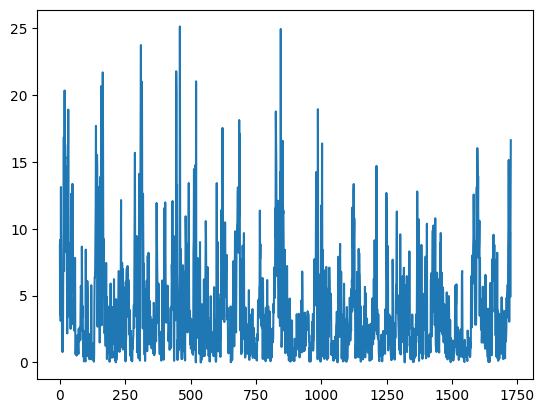

In [23]:
plt.plot(errs)

In [18]:
confs

array([3.89846286, 3.89010678, 3.79506726, ..., 0.82203329, 0.90377482,
       0.58531102])

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 